# Land Cover Continuous Monitoring Service (LC-CMS) Workshop
!["workshop_code/images/lccms_pipeline.PNG"](images/lccms_pipeline.png)

# A : Pre-Requirsites
- Docker engine >= 10.0
- QGIS : To visualize the Predictions & Results. Template for the project is provided in this repository.
- Local disk space ~ 3GB
- RAM >= 4 GB
- Optional things :
    - SentinelHub Account( If you want to visualize using BYOC services / EOBrowser). This will also require an S3 bucket which should be accessible using the SH. This will not be covered in this workshop but links will be provided so, that you can do it yourself.
    
## A.1 : Dataset for the Notebook (***Very Important***) :
In order to run this Notebook, we'll need some dataset on which we can perform Land Classification. We'll use the dataset already prepared for Paris region for the purpose of this exercise, so **please make sure to download it before the workshop using following steps** : 
1. Download the data from the following download link : 
    https://cloud.sinergise.com/s/TJnrDjbT2tpiGA2

     Alternatively, you can use following wget command : 

`wget https://cloud.sinergise.com/s/TJnrDjbT2tpiGA2/download/paris_run.zip -O paris_run.zip`

2. The first step will download a **paris_run.zip** file. You can unzip it on your machine for now. 

**You will need this later while running the docker image, where you'll mount this directory to the docker container.**

The downloaded dataset `paris_run` should have data for two years **2020 & 2021** with following structure : 

!["workshop_code/images/paris_dataset_view.png"](images/paris_dataset_view.png)

## A.2 : QGIS Template for Visualizing the results
There is QGIS directly in the repository, which contains the project file => **lc_cms_reslut_viewer.qgz**. 
Import it as a project in QGIS so that you can visualize the results later on.


# B : How to run this notebook ?
## B.1 : If you're using Docker :
There is an associated Dockerfile in this repository, which installs all the necessary packages required to run this notebook. 

Additionaly, once the dockerfile is run, it also spins up a jupyter notebook in the container which can be accessed using a public port.
1. As a first step, you can build the docker image by going to the home directory using command :

`
docker build -t gem-workshop:latest .
`

2. Next run the docker image which starts a jupyter notebook (Please make sure the port that you are using is not being using by some other process):

`
docker run -p 8888:8888 -v $(pwd):/gem-workshop -v $paris_run:/gem-workshop/paris_run -t gem-workshop:latest
`

**Note : `$paris_run` must be replaced by path to directly where you have downloaded the data as mentioned in section pre-requisites A.1**

**If you're on windows You will have to replace $(pwd) with path to the `LC_CMS_Workshop` in the checked out repository.**

3. You can now go to the link http://localhost:8888 and enter the password as **`gem`**. Then, open the jupyter notebook at location notebook/LC-CMS_Workshop.ipynb.


## B.2 : If you are not using Docker :
As an alternate if you are not using the Docker, you can install the following requirements/packages manually :
- Python >= 3.9
- Gdal binaries >= 3.23
- Gdal-python >= 3.23
- All the packages listed in requirements.txt of this repo :
   - sentinelhub>=3.6.3
   - eo-learn==1.3.1
   - eo-grow==1.3.3
   - geopandas==0.12.2
   - scikit-learn==1.2.0
   - scikit-image==0.19.3
   - scipy==1.10.0
   - juypyterlab
   
## Contact Details :
### Ashish Dhiman
#### Work Email : ashish.dhiman@tomtom.com
#### Personal Email : ashish.dhiman.nith@gmail.com
#### LinkedIn : https://www.linkedin.com/in/ashishdhiman89/

# LC-CMS Pipeline Steps
The following diagram shows the overview of the entire pipeline.
The pipeline consists of different phases : 
1. Data Collection

This phase consists of prepration of data that is required for the pipeline. 

2. Modelling
3. Serving




!["Title"](images/pipeline_overview.PNG)

# EOGrow 101 [Optional]
* Before we begin, a quick summary of EOGrow Pipelines.
* For more details, please check this repository [https://github.com/sentinel-hub/eo-grow](https://github.com/sentinel-hub/eo-grow). It contains some notebooks and examples to help you with it
!["images/eogrow_basics.png"](images/eogrow_basics.png)

**Global Config** : This configuration will be shared by all of the pipeline steps. More information can be found on the [ReadMe](https://github.com/sentinel-hub/eo-grow) of eo-grow repository.

Using the global configuration in our `config_files/global_config.json` we have, will result in following directory structure :

!["Directory Structure"](images/directory_structure.png)

**Before we begin, let's import some of the modules that we'll need**

In [1]:
# imports
import os
import joblib
import matplotlib
import matplotlib.pyplot as plt
from eolearn.core import EOPatch
import numpy as np
import seaborn as sns
import rasterio
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
%matplotlib inline

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Also, initialize some variable that we might need later
RUN_DIR = '/gem-workshop/paris_run/2020'
LABELS_ORIG = {1: 'forest',
               2: 'grass',
               3: 'farmland',
               4: 'bare soil',
               5: 'sand',
               6: 'built-up',
               7: 'permanent water',
               8: 'intermittent water',
               9: 'eternal snow'}
INPUT_BANDS = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12"]

# 1. Load Batch
1. We use the step *eogrow.pipelines.download_batch.BatchDownloadPipeline* from the eo-grow library for this purpose. **For the purpose of this workshop, the data is already provided to you.**
2. Generally, in this step we request the input data that we are interested in using the the SentinelHub's [BatchAPI](https://docs.sentinel-hub.com/api/latest/api/batch/). The data is delivered asynchronously to an S3 bucket as spacial tiles (based on the tiling scheme).
2. There is an associated [evalscript.js](./evalscript_S2.js) & an eo-grow configuration file which can be used to specify what kind of data should be downloaded. See this link for more details : https://docs.sentinel-hub.com/api/latest/evalscript/
!["Batch Download"](images/batch_download.png)


### Download the output files of the BatchDownload Step
- This is the first step of the pipeline but it has already been executed. We use the BatchAPI which delivers data asynchronously to S3, which can take time. 
- So, for the scope of this workshop, we've already executed and the output of this step by using the command below. The command downloads the data for Paris city in France.
- The data includes :
    - `batch_output` directory => Output of LoadBatch step in the 
    - `cache` => Cache generated while executing the DownloadBatch step
    - `input-data` => The geomerty of Input AOI of Orleans region in France
    - `training_data` => The training polygons over the Orleans region to label the training data pixels for various classes


# 2. Batch To EOPatch Step
!["images/batch_to_eopatch.png"](images/batch_to_eopatch.png)
- Here, we convert the TIFF files downloaded in the LoadBatch step to the [EO Patches](https://eo-learn.readthedocs.io/en/latest/examples/core/CoreOverview.html). 
- EO Patches are just the DataCubes of dimensions `T X H X W X C` where T = temporal dimensions, H & W are height and width of the tile, C is the bands or channels of the sensor input data. For example : we are using Sentinel-2 data (with 12 bands B1, ..., B12) for 1 year which is aggregated every two month (i.e. 6 measurements in a year). So, the in our case, the data cubes will be of dimensions `6 X H X W X 12`.

In [3]:
# we can always run eogrow-validate to validate if our configuation file for our Pipeline is setup correctly
!eogrow-validate config_files/batch_to_eopatch.json

/usr/local/lib/python3.10/site-packages/eolearn/io/sentinelhub_process.py:36: SHDeprecationWarning: The module `sentinelhub.type_utils` is deprecated, use `sentinelhub.types` instead.
  from sentinelhub.type_utils import RawTimeIntervalType
Config validation succeeded!


In [4]:
# If the validation ran successfully, we can run the pipeline using the eogrow command from the command line.
!eogrow config_files/batch_to_eopatch.json

/usr/local/lib/python3.10/site-packages/eolearn/io/sentinelhub_process.py:36: SHDeprecationWarning: The module `sentinelhub.type_utils` is deprecated, use `sentinelhub.types` instead.
  from sentinelhub.type_utils import RawTimeIntervalType
INFO eogrow.core.pipeline:236: Running BatchToEOPatchPipeline
INFO eogrow.core.area.base:208: Loading grid from cache/grid_paris-aoi_BatchAreaManager___0_60.0_0_0.gpkg
INFO eogrow.utils.ray:24: No Ray cluster found, will not use Ray.
INFO eogrow.core.pipeline:193: Starting EOExecutor for 9 EOPatches
100%|█████████████████████████████████████████████| 9/9 [00:12<00:00,  1.44s/it]
INFO eogrow.core.pipeline:208: EOExecutor finished with 9 / 9 success rate
INFO eogrow.core.pipeline:217: Saved EOExecution report to /gem-workshop/paris_run/2020/logs/2023-02-08T14-34-47Z-BatchToEOPatchPipeline-6df1a84977/eoexecution-report-2023_02_08-14_34_48/report.html
INFO eogrow.core.pipeline:248: Pipeline finished successfully!


## 2.1 Let's visualize the output of one of the EOPatches that we downloaded

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


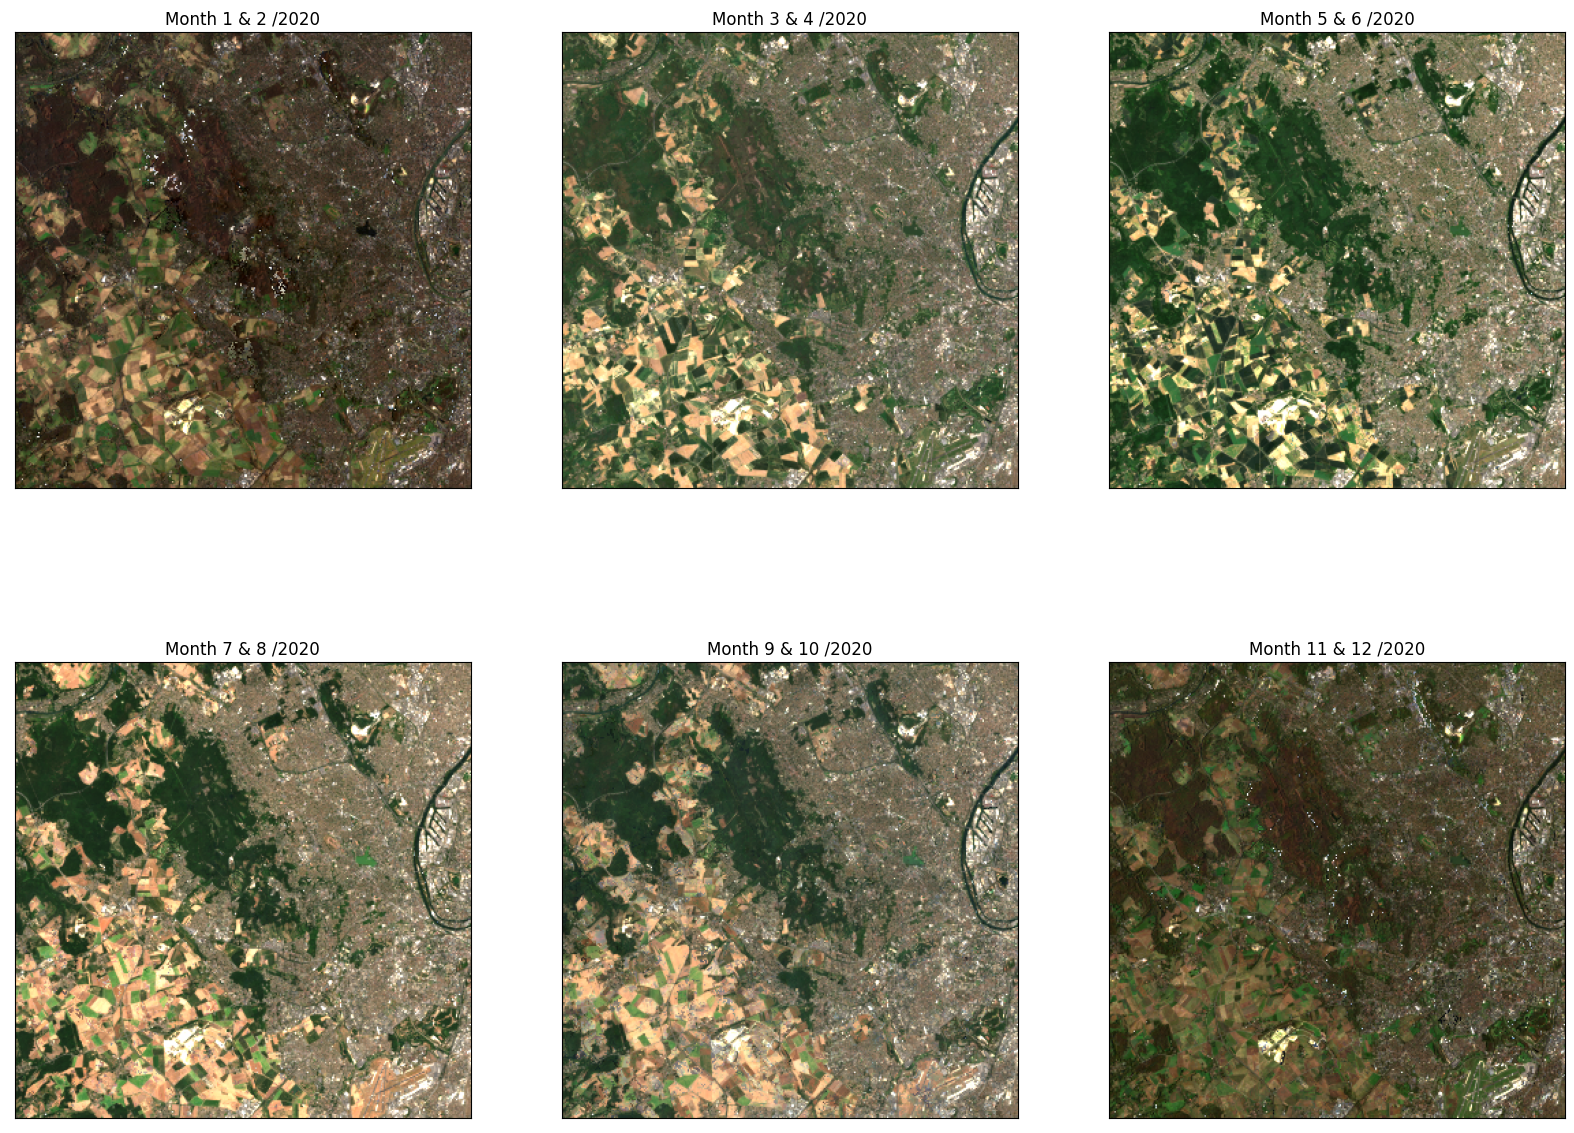

In [5]:
# Now, plot the distribution to have a better picture
%matplotlib inline
# Provide the path to the Tile that you want to visualize
eopatch_path = f'{RUN_DIR}/eo-patch_features/raw_features/31UDQ_2_3' # 31UDQ_2_3, 31UDP_2_0

# We can use the EOPatch.load function to load the data. We can always use lazy_loading when we want to.
eopatch = EOPatch.load(eopatch_path) #, lazy_loading=True)

# The following functions prints the visual bands (B2, B3, B4 <-> (blue, green, red)) for the selected EOPatch for the aggreegated six months of the year.
# Please go ahead and try printing this for different EOPatches
fig, axes = plt.subplots(2, 3, figsize=(20, 15))
# fig.set_size_inches((8, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow((eopatch.data['BANDS'][i, :, :, [3, 2, 1]].T / 10000) *  5.5)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'Month {2*i+1} & {2*i+2} /2020')

##Go back and generate this for a different tile

# 3. Prepare Training
- The goal of this step is to craft the InputFeatures which can be used for training the ML model for LC-CMS pipeline.
- This step really depends on how the data is captured and how your ML model and workflow looks like.
- For the purposes of this step we'll create an **new EOGrow pipeline** & and a **new EOLearn task** to load the data.

We will import the custom eo-grow pipeline **PrepareTrainingDataPipeline** from the provided python file *prepare_train.py*
!["images/prepare_training.png"](images/prepare_training.png)

In [6]:
# Import the pipeline and the os module to read the file
from prepare_train import PrepareTrainingDataPipeline

# First, we need to read the config file for the pipeline
config_path = os.path.join('config_files', 'prepare_train.json')

# Then we can build an eo-grow Pipeline object for this pipeline as follows :
pre_train_pipeline = PrepareTrainingDataPipeline.from_path(config_path)

In [7]:
# Finally, we can run this pipeline using the run() method on the pipeline.
pre_train_pipeline.run()

INFO eogrow.core.pipeline:236: Running PrepareTrainingDataPipeline
INFO eogrow.core.area.base:208: Loading grid from cache/grid_paris-aoi_BatchAreaManager___0_60.0_0_0.gpkg
INFO eogrow.utils.ray:24: No Ray cluster found, will not use Ray.
INFO eogrow.core.pipeline:193: Starting EOExecutor for 9 EOPatches


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.07it/s]

INFO eogrow.core.pipeline:208: EOExecutor finished with 9 / 9 success rate
INFO eogrow.core.pipeline:217: Saved EOExecution report to /gem-workshop/paris_run/2020/logs/2023-02-08T14-35-18Z-PrepareTrainingDataPipeline-93b6f55cb1/eoexecution-report-2023_02_08-14_35_19/report.html



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.30it/s]


INFO eogrow.core.pipeline:248: Pipeline finished successfully!


 **The output of this step is two ND-arrays** :
 - `training_features.npy` => Stores the Crafted input features
 - `training_labels.npy` => Stores the labels correspoinding to all the training features
 
Lets calculate some statistics about out consolidated training data before we train our ML model

In [8]:
# Load the training features & labels from the training_data directory
training_data = np.load(f'{RUN_DIR}/training_data/training_features.npy')
training_labels = np.load(f'{RUN_DIR}/training_data/training_labels.npy')
print(training_data.shape, training_labels.shape)
# Calculate the distribution of labels
label_distribution = np.unique(training_labels, return_counts=True)

(640, 72) (640,)


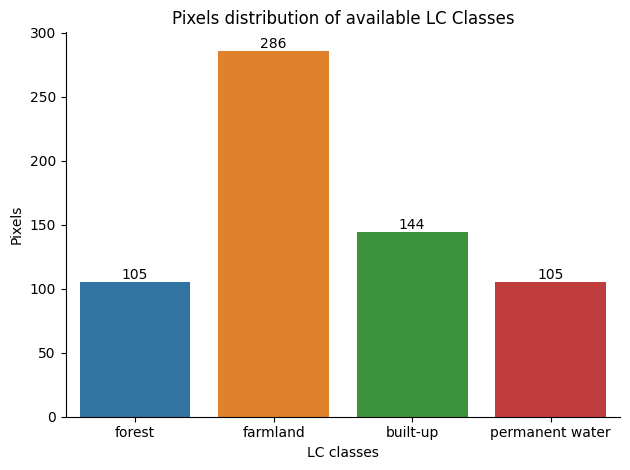

In [9]:
# Now, plot the distribution to have a better picture
%matplotlib inline
target_names = [LABELS_ORIG[l] for l in label_distribution[0]]
ax = sns.barplot(y=label_distribution[1], x=target_names, orient='v')
ax.set(title='Pixels distribution of available LC Classes', ylabel='Pixels', xlabel='LC classes')
ax.bar_label(ax.containers[0], labels=label_distribution[1])
# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.figure.tight_layout()
# plt.show()

# 4. Training Step

**It time to train our LC Classificaiton model.**
- We use a LightGBM Random Forest Classification model.
- For this workshop, we will use the ***ClassificationTrainingPipeline*** which already comes with the eo-grow package : *eogrow.pipelines.training*
- If needed, we can modify the model parameters like num_classes, weight by modifying the config file.

In [10]:
# Run the training pipeline step
!eogrow config_files/training.json

INFO eogrow.core.pipeline:236: Running ClassificationTrainingPipeline
INFO eogrow.pipelines.training:80: Preparing data
INFO eogrow.pipelines.training:109: Reading input features
INFO eogrow.pipelines.training:120: Reading input reference
INFO eogrow.pipelines.training:213: Applying label encoder to labels
INFO eogrow.pipelines.training:164: Saving to lc-cms-LE.pkl
INFO eogrow.pipelines.training:135: Making a random train-test split, using 0.8 of data for training.
INFO eogrow.pipelines.training:83: Training. This could take a while.
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
INFO eogrow.pipelines.training:86: Saving.
INFO eogrow.pipelines.training:164: Saving to lc-cms_model.pkl
INFO 

In [11]:
# We can now load our saved model and generate some stats
_, val_data, _, val_labels = train_test_split(training_data, training_labels, random_state=99, train_size=0.8, stratify=training_labels)
print(val_data.shape, val_labels.shape)

# Load the LGBMClassifier and the LabelEncoder which are saved as an output of training step
with open(f'{RUN_DIR}/model/lc-cms-LE.pkl', 'rb') as f:
    label_encoder: LabelEncoder = joblib.load(f)
with open(f'{RUN_DIR}/model/lc-cms_model.pkl', 'rb') as f:
    model: LGBMClassifier = joblib.load(f)

(128, 72) (128,)


In [12]:
# Generate the classification report on the Validation dataset
val_preds = model.predict(val_data)
print(classification_report(val_labels, label_encoder.inverse_transform(val_preds)))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        21
           3       1.00      0.98      0.99        57
           6       0.97      1.00      0.98        29
           7       1.00      1.00      1.00        21

    accuracy                           0.99       128
   macro avg       0.99      1.00      0.99       128
weighted avg       0.99      0.99      0.99       128



[Text(0, 0.5, 'T1'),
 Text(0, 1.5, 'T2'),
 Text(0, 2.5, 'T3'),
 Text(0, 3.5, 'T4'),
 Text(0, 4.5, 'T5'),
 Text(0, 5.5, 'T6')]

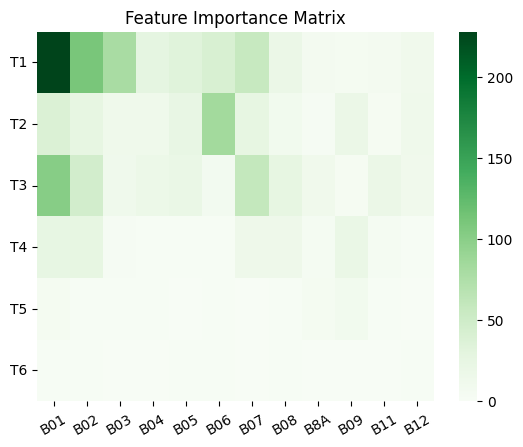

In [13]:
# We can also have a look at the Feature Importance matrix to see which features player more significant role while predicting
%matplotlib inline
y_labels = [f'T{i}' for i in range(1, (len(model.feature_importances_) // len(INPUT_BANDS)) + 1)]
ax = sns.heatmap(model.feature_importances_.reshape(len(y_labels), len(INPUT_BANDS)), annot=False, cmap=plt.cm.Greens,
                     xticklabels=INPUT_BANDS,
                     yticklabels=y_labels)
ax.set(title='Feature Importance Matrix')
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

Best Threshold for forest 0.495, G-Mean=1.00
Best Threshold for farmland 0.323, G-Mean=1.00
Best Threshold for built-up 0.660, G-Mean=1.00
Best Threshold for permanent water 0.904, G-Mean=1.00


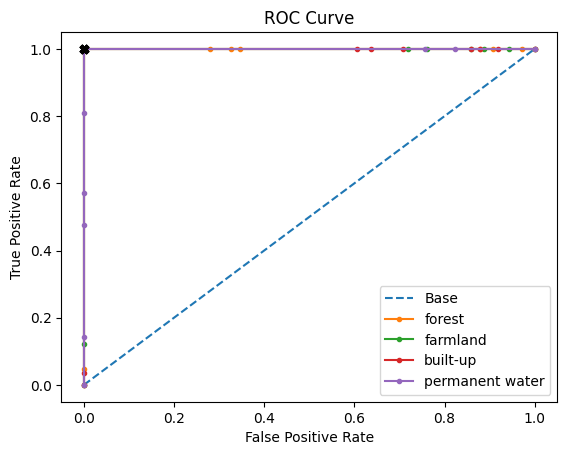

In [14]:
# Lastly, we can also have a look at ROC curve to see the bevavious of predictions for different thresholds
%matplotlib inline
val_proba = model.predict_proba(val_data)

display_labels = [LABELS_ORIG[l] for l in label_distribution[0]]
plt.plot([0, 1], [0, 1], linestyle='--', label='Base')
for i in range(4):
    fpr, tpr, thresholds = roc_curve(label_encoder.transform(val_labels), val_proba[:, i], pos_label=i)
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    # print(fpr)
    print(f'Best Threshold for {display_labels[i]} {thresholds[ix]:0.3f}, G-Mean={gmeans[ix]:0.2f}')
    plt.scatter(fpr[ix], tpr[ix], marker='X', color='black', zorder=10)    
    plt.plot(fpr, tpr, marker='.', label=display_labels[i])
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
# show the legend
plt.legend()
# show the plot
plt.show()

# 5. Prediction
Now, that everythink looks good and if we are confident that model is behaving as expected, we can start performing predictions for all the EOPatches using the trained model.
- For this purpose, will use the **ClassificationPredictionPipeline** from the *eogrow.pipelines.prediction* module of *eo-grow*
- It performs the prediction & calculates class probabilities on every EOPatch

In [15]:
# Run the prediction step
!eogrow config_files/prediction.json

INFO eogrow.core.pipeline:236: Running ClassificationPredictionPipeline
INFO eogrow.core.area.base:208: Loading grid from cache/grid_paris-aoi_BatchAreaManager___0_60.0_0_0.gpkg
INFO eogrow.utils.ray:24: No Ray cluster found, will not use Ray.
INFO eogrow.core.pipeline:193: Starting EOExecutor for 9 EOPatches
100%|█████████████████████████████████████████████| 9/9 [00:09<00:00,  1.04s/it]
INFO eogrow.core.pipeline:208: EOExecutor finished with 9 / 9 success rate
INFO eogrow.core.pipeline:217: Saved EOExecution report to /gem-workshop/paris_run/2020/logs/2023-02-08T14-35-47Z-ClassificationPredictionPipeline-ff65c55a12/eoexecution-report-2023_02_08-14_35_47/report.html
INFO eogrow.core.pipeline:248: Pipeline finished successfully!


# 6. Exporting & Serving
* This step is used to change the output from the EOPatch format back to the tiff or the desired output format. It can be thought of inverse of the first BatchToEOPatch Step.
* In addition to exporting, it also concatenates the output per UTM zone.

In [16]:
# Let's go ahead and run this step
!eogrow config_files/export_pred.json

/usr/local/lib/python3.10/site-packages/eolearn/io/sentinelhub_process.py:36: SHDeprecationWarning: The module `sentinelhub.type_utils` is deprecated, use `sentinelhub.types` instead.
  from sentinelhub.type_utils import RawTimeIntervalType
INFO eogrow.core.pipeline:236: Running ExportMapsPipeline
INFO eogrow.core.area.base:208: Loading grid from cache/grid_paris-aoi_BatchAreaManager___0_60.0_0_0.gpkg
INFO eogrow.utils.ray:24: No Ray cluster found, will not use Ray.
INFO eogrow.core.pipeline:193: Starting EOExecutor for 9 EOPatches
100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 26.06it/s]
INFO eogrow.core.pipeline:208: EOExecutor finished with 9 / 9 success rate
INFO eogrow.core.pipeline:217: Saved EOExecution report to /gem-workshop/paris_run/2020/logs/2023-02-08T14-36-01Z-ExportMapsPipeline-657d3a5b03/eoexecution-report-2023_02_08-14_36_02/report.html
INFO eogrow.pipelines.export_maps:131: Processing UTM 32631
INFO eogrow.pipelines.export_maps:154: Merging TIFF

# 7. Summary
* We executed all the steps in Green color
* All the steps in grey boxes were provided already
* We can now use the output of this pipeline for downstream processes for example Change Detection
!["images/conclusion.png"](images/conclusion.png)

# 8. Change Detection [Optional]
* There are various approaches to detecting change and in this artilce we are going to look at one of them which is monitoring changes using the predicted output.
* This can be simply done by taking a diff of predictions between two time periods of predictions.
!["images/change_detection.png"](images/change_detection.png)

### The **results of LC-CMS & Change Detection** can be viewed at the following link : https://www.globalearthmonitor.eu/sites/default/files/LC_CMS/index.html

**We can now run the LC-CMS pipeline for different year (year 2021). The training data we'll assume remains the same.**

In [ ]:
# First, change the project_dir in the global configuration to the new 2021 project_dir that we want to perform the run for.
# Also, change the RUN_DIR so that everything is referenced properly
RUN_DIR = '/gem-workshop/lccms_rundir/paris_run/2021'

In [ ]:
# Run all the steps one by one
# We first run the Batch To EOPatch pipeline step
!eogrow config_files/batch_to_eopatch.json

In [ ]:
# Run PrepareTraining step 
config_path = os.path.join('config_files', 'prepare_train.json')
# Then we can build an eo-grow Pipeline object for this pipeline as follows :
prepare_train_pipeline = PrepareTrainingDataPipeline.from_path(config_path)
prepare_train_pipeline.run()

In [ ]:
# Run Training step
!eogrow config_files/training.json

In [ ]:
# Run Prediction step
!eogrow config_files/prediction.json

In [ ]:
# Run Export Predictions step
!eogrow config_files/export_pred.json

**Now that we have the prediction for both 2020 & 2021, we can take the diff between the predictios to detect the change**

*The `generate_change_detection_using_diff` function can generate the Diff of the predictions between 2020 & 2021 for us.*

In [ ]:
def generate_change_detection_using_diff(from_preds_path, to_preds_path, diff_path):
    """
    This function generates the diff between the the LC-CMS predictions taken over two different time periods.
    For example, if we can generate change b/w  predictions of year 2020 and 2021.
    Both input and output should be of same size.
    Parameters
    ----------
    from_preds_path : Predictions from which diff should be taken
    to_preds_path : Predictions to which diff should be taken
    diff_path : Path where diff should be stored.

    Returns
    -------

    """
    with rasterio.open(from_preds_path) as f:
        preds_from = f.read()
        input_profile = f.profile
        with rasterio.open(to_preds_path) as f:
            preds_to = f.read()
            pred_diff = np.where(preds_from != preds_to, preds_to, 255.)
            with rasterio.open(diff_path, 'w', **input_profile) as f:
                f.write(pred_diff)
                print(f'Successfully generated prediction at location => {diff_path}')

In [ ]:
# We can call this function with from year, to year and the diff_path where we need to store the output :
generate_change_detection_using_diff(from_preds_path='/gem-workshop/lccms_rundir/paris_run/2020/serve/UTM_32631/PRED.tiff', 
                                     to_preds_path='/gem-workshop/lccms_rundir/paris_run/2021/serve/UTM_32631/PRED.tiff', 
                                     diff_path='/gem-workshop/lccms_rundir/paris_run/change_2020_2021.tiff')

**This output can be imported in the QGIS now.**